# Preprocessing, k-Nearest Neighbors (Bill Lee)

# Support Vector Machine (Lester Fan)

# k-Means Clustering (Anton Maliev)

### Preprocessing

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
import glob
from skimage.io import imread

daisy,dandelion,rose,sunflower,tulip = [],[],[],[],[]

for filename in glob.glob('flowerscomp/daisy/*.jpg'): # for daisies
    im = imread(filename,True).flatten()
    daisy.append(im)    

for filename in glob.glob('flowerscomp/dandelion/*.jpg'): # for dandelion
    im = imread(filename,True).flatten()
    dandelion.append(im)
    
for filename in glob.glob('flowerscomp/rose/*.jpg'): # for roses
    im = imread(filename,True).flatten()
    rose.append(im)
    
for filename in glob.glob('flowerscomp/sunflower/*.jpg'): # for sunflowers
    im = imread(filename,True).flatten()
    sunflower.append(im)
    
for filename in glob.glob('flowerscomp/tulip/*.jpg'): # for tulip
    im = imread(filename,True).flatten()
    tulip.append(im)

In [2]:
daisy_arr=np.asarray(daisy)
dandelion_arr=np.asarray(dandelion)
rose_arr=np.asarray(rose)
sunflower_arr=np.asarray(sunflower)
tulip_arr=np.asarray(tulip)

# daisy = 0, dandelion = 1, rose = 2, sunflower = 3, tulip = 4
daisy_labels=np.zeros((len(daisy_arr),1))
dandelion_labels=np.ones((len(dandelion_arr),1))
rose_labels=2*np.ones((len(rose_arr),1))
sunflower_labels=3*np.ones((len(sunflower_arr),1))
tulip_labels=4*np.ones((len(tulip_arr),1))


# Here are the labels and the dataset 
labels=np.vstack((daisy_labels,dandelion_labels,rose_labels,sunflower_labels,tulip_labels))
dataset=np.vstack((daisy_arr,dandelion_arr,rose_arr,sunflower_arr,tulip_arr))

### PCA on Dataset

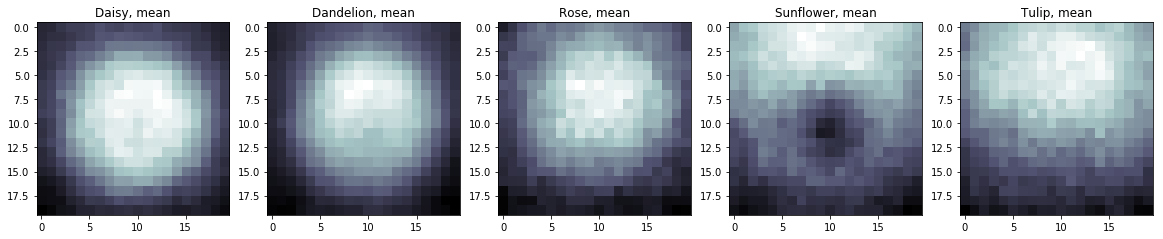

In [18]:
# means of the photos
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,5,1)
plt.imshow(np.reshape(daisy_arr.mean(0),(20,20)),cmap='bone')
plt.title("Daisy, mean")
fig.add_subplot(1,5,2)
plt.imshow(np.reshape(dandelion_arr.mean(0),(20,20)),cmap='bone')
plt.title("Dandelion, mean")
fig.add_subplot(1,5,3)
plt.imshow(np.reshape(rose_arr.mean(0),(20,20)),cmap='bone')
plt.title("Rose, mean")
fig.add_subplot(1,5,4)
plt.imshow(np.reshape(sunflower_arr.mean(0),(20,20)),cmap='bone')
plt.title("Sunflower, mean")
fig.add_subplot(1,5,5)
plt.imshow(np.reshape(tulip_arr.mean(0),(20,20)),cmap='bone')
plt.title("Tulip, mean");

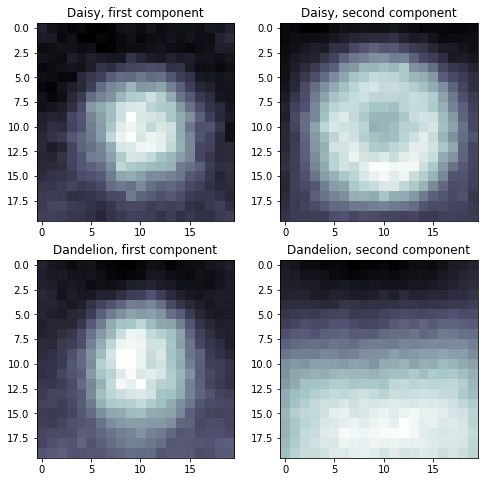

In [4]:
# Printing top principal components 
fig=plt.figure(figsize=(8,8))
centered_daisy = daisy_arr.T-np.reshape(daisy_arr.T.mean(1),(400,1))
centered_dandelion = dandelion_arr.T-np.reshape(dandelion_arr.T.mean(1),(400,1))
u1,s1,v1 = np.linalg.svd(centered_daisy)
u2,s2,v2 = np.linalg.svd(centered_dandelion)
component1,component2 = u1[:,[0]],u1[:,[1]]
component3,component4 = u2[:,[0]],u2[:,[1]]
fig.add_subplot(221)
plt.imshow(np.reshape(component1,(20,20)),cmap='bone')
plt.title("Daisy, first component")
fig.add_subplot(222)
plt.imshow(np.reshape(component2,(20,20)),cmap='bone')
plt.title("Daisy, second component");
fig.add_subplot(223)
plt.imshow(np.reshape((component3),(20,20)),cmap='bone')
plt.title("Dandelion, first component")
fig.add_subplot(224)
plt.imshow(np.reshape((component4),(20,20)),cmap='bone')
plt.title("Dandelion, second component");


In [5]:
# Centering the dataset 
mean=np.reshape(dataset.T.mean(1),(len(dataset.T),1))
centered=dataset.T-mean

U,S,V=np.linalg.svd(centered)

# Determining Variation
total_s = 0
fnorm = np.linalg.norm(centered,'fro')
for k in range(2,12):
    total_s += S[k]**2
    print(k,(total_s/fnorm**2)*100)


2 5.757591985151745
3 9.444942355390555
4 11.722801207886233
5 13.824002313590968
6 15.553334248664816
7 17.13672651991847
8 18.579921087899326
9 19.72138127196501
10 20.737943419024216
11 21.651832851092376


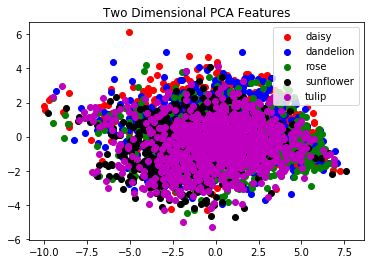

In [6]:
# Visualization of the datapoints 

p2c = (U[:,[0,1]].T@centered).T
points = [p2c[0:768],p2c[768:1820],p2c[1820:2603],p2c[2603:3337],p2c[3337:4321]]
colors = ['r','b','g','k','m']
which_flower = ['daisy','dandelion','rose','sunflower','tulip']
fig = plt.figure()

for i in range(5):
    x,y = points[i][:,0], points[i][:,1]
    plt.scatter(x,y,c=colors[i],label=which_flower[i])
plt.title('Two Dimensional PCA Features')
plt.legend(loc='upper right');

In [7]:
finalTopk=U[:,0:8]
new_dataset=finalTopk.T@centered

def scramble(samples,labels):
    fix_labels=np.reshape(labels,(1,labels.shape[0]))
    mashed = np.vstack((samples,fix_labels)).T
    np.random.shuffle(mashed)
    labels_out = mashed.T[mashed.T.shape[0]-1]
    samples_out = mashed.T[0:mashed.T.shape[0]-1]
    return [samples_out,labels_out]
    
workable_samples, workable_labels = scramble(new_dataset,labels)

In [14]:
from heapq import heappush, heappop
from scipy import stats

def kNN(k,testset,testlabels,trainset,trainlabels):
    # distance stores threeple (euclidan distance, training class, actual test class)
    confusion = np.zeros((5,5))
    for i in range(len(testset)):
        distances = []
        for j in range(len(trainset)):
            heappush(distances,(np.linalg.norm(testset[i]-trainset[j]),trainlabels[j]))
    
        # now take the k nearest
        tally = []
        for near in range(k):
            tally.append(heappop(distances)[1])
        
        winner = int(stats.mode(tally)[0])
        confusion[int(testlabels[i])][winner] += 1
    
    return confusion
        

def fiveFoldCV(data,labels):
    mega_confusion=[]
    for k in range(1,10,2):
        total_confusion = np.zeros((5,5))
        for i in range(5):
            sindex1 = (i*864)
            sindex2 = 4321 if i==4 else (i+1)*864
            test_set = data[sindex1:sindex2]
            test_labels = labels[sindex1:sindex2]
            training_set = np.concatenate((data[sindex2:4321],data[0:sindex1]))
            training_labels = np.concatenate((labels[sindex2:4321],labels[0:sindex1]))
            temp_confusion = kNN(k, test_set, test_labels, training_set, training_labels)
            total_confusion += temp_confusion
        mega_confusion.append(total_confusion)
        
    return mega_confusion
 
mega_confusion = fiveFoldCV(workable_samples.T,workable_labels)


k (nearest neighbors) 1 with confusion matrix [[206. 219. 116. 105. 122.]
 [176. 366. 171. 149. 190.]
 [116. 177. 190. 113. 187.]
 [105. 145. 109. 219. 156.]
 [127. 193. 176. 166. 322.]]
k (nearest neighbors) 3 with confusion matrix [[304. 256.  82.  45.  81.]
 [322. 414. 114.  82. 120.]
 [213. 217. 169.  58. 126.]
 [158. 196.  93. 172. 115.]
 [238. 236. 135. 101. 274.]]
k (nearest neighbors) 5 with confusion matrix [[235. 277.  90.  72.  94.]
 [221. 433. 131. 124. 143.]
 [141. 202. 183. 111. 146.]
 [100. 188.  83. 228. 135.]
 [146. 208. 156. 148. 326.]]
k (nearest neighbors) 7 with confusion matrix [[220. 303.  82.  62. 101.]
 [212. 460. 110. 118. 152.]
 [137. 224. 174.  81. 167.]
 [ 87. 193.  72. 221. 161.]
 [134. 209. 136. 142. 363.]]
k (nearest neighbors) 9 with confusion matrix [[191. 311.  88.  62. 116.]
 [189. 461. 106. 127. 169.]
 [108. 222. 173.  93. 187.]
 [ 72. 172.  59. 254. 177.]
 [102. 195. 122. 160. 405.]]


In [15]:
for i in range(len(mega_confusion)):
    print("k (nearest neighbors)",((2*i)+1),"with confusion matrix\n",mega_confusion[i])

k (nearest neighbors) 1 with confusion matrix
 [[206. 219. 116. 105. 122.]
 [176. 366. 171. 149. 190.]
 [116. 177. 190. 113. 187.]
 [105. 145. 109. 219. 156.]
 [127. 193. 176. 166. 322.]]
k (nearest neighbors) 3 with confusion matrix
 [[304. 256.  82.  45.  81.]
 [322. 414. 114.  82. 120.]
 [213. 217. 169.  58. 126.]
 [158. 196.  93. 172. 115.]
 [238. 236. 135. 101. 274.]]
k (nearest neighbors) 5 with confusion matrix
 [[235. 277.  90.  72.  94.]
 [221. 433. 131. 124. 143.]
 [141. 202. 183. 111. 146.]
 [100. 188.  83. 228. 135.]
 [146. 208. 156. 148. 326.]]
k (nearest neighbors) 7 with confusion matrix
 [[220. 303.  82.  62. 101.]
 [212. 460. 110. 118. 152.]
 [137. 224. 174.  81. 167.]
 [ 87. 193.  72. 221. 161.]
 [134. 209. 136. 142. 363.]]
k (nearest neighbors) 9 with confusion matrix
 [[191. 311.  88.  62. 116.]
 [189. 461. 106. 127. 169.]
 [108. 222. 173.  93. 187.]
 [ 72. 172.  59. 254. 177.]
 [102. 195. 122. 160. 405.]]


In [16]:
k = 1
for matrix in mega_confusion:
    correct = 0
    total = 0
    for i in range(5):
        for j in range(5):
            if(i==j):
                correct+=matrix[i][j]
            total += matrix[i][j]
    k += 2
    print(k, "with correct classification percentage", (correct/total)*100)
            
                

3 with correct classification percentage 30.155056699838
5 with correct classification percentage 30.849340430455914
7 with correct classification percentage 32.5156213839389
9 with correct classification percentage 33.27933348761861
11 with correct classification percentage 34.34390187456607
